In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import MLP
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import InversionAttack
from tqdm.notebook import tqdm
from attack_helper import batched_predictions, batched_predictions, batched_logits
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
from typing import Tuple, List

def run_batched_attack_cpu(attack, fmodel, images, labels, epsilons, bs) -> Tuple[List[torch.Tensor], List[torch.Tensor], torch.Tensor]:
    assert len(images) == len(labels)
    n_samples = len(labels)
    assert n_samples % bs == 0, f'The batch size ({bs}) must be a divisor of number of samples ({n_samples}).'
    with tqdm(total=n_samples//bs) as pbar:
        raw_advs, clipped_advs, success = attack(fmodel, ep.astensor(images[:bs].cuda()), ep.astensor(labels[:bs].cuda()), epsilons=epsilons)
        raw_advs_cpu = torch.stack([raw_advs[i].raw.cpu() for i in range(len(raw_advs))])
        clipped_advs_cpu = torch.stack([clipped_advs[i].raw.cpu() for i in range(len(clipped_advs))])
        success_cpu = success.raw.cpu()
        pbar.update(1)

        for i in range(1,n_samples//bs):
            raw_advs, clipped_advs, success = attack(fmodel, ep.astensor(images[bs*i:bs*(i+1)].cuda()), ep.astensor(labels[bs*i:bs*(i+1)].cuda()), epsilons=epsilons)
            dummy_raw_advs_cpu = torch.stack([raw_advs[i].raw.cpu() for i in range(len(raw_advs))])
            dummy_clipped_advs_cpu = torch.stack([clipped_advs[i].raw.cpu() for i in range(len(clipped_advs))])
            dummy_success_cpu = success.raw.cpu()
            
            raw_advs_cpu = torch.cat((raw_advs_cpu, dummy_raw_advs_cpu), axis=0)
            clipped_advs_cpu = torch.cat((clipped_advs_cpu, dummy_clipped_advs_cpu), axis=0)
            success_cpu = torch.cat((success_cpu, dummy_success_cpu), axis=0)
            pbar.update(1)
            
    return raw_advs_cpu, clipped_advs_cpu, success_cpu

In [3]:
run_name = 1697314773
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = MLP(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])

test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])

if df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0] is None:
    flat = False
else:
    flat = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0])

if flat:
    padded_img_size = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.padded_img_size'].values[0])

    if test_rot:
        TEST_PATH = "flat_mnist_test_aug_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"
    else:
        TEST_PATH = "flat_mnist_test_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"

    test_data = load_train_data(TEST_PATH)

else:    
    if test_rot:
        TEST_PATH = "s2_mnist_cs1.gz"
        test_data = load_test_data(TEST_PATH)
    else:
        TEST_PATH = "s2_mnist_test_sphere_center.gz"
        test_data = load_train_data(TEST_PATH)

In [4]:
total = 10000
bs = 1000

images = test_data[:total][0]
labels = test_data[:total][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

In [5]:
clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = InversionAttack()

In [7]:
_, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, None, bs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
adv_pred = batched_predictions(model, advs, bs)
logits = batched_logits(model, advs, bs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
success_rate

tensor(0.8952)

7 7


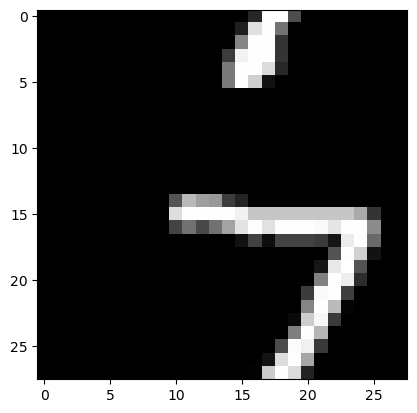

8 7


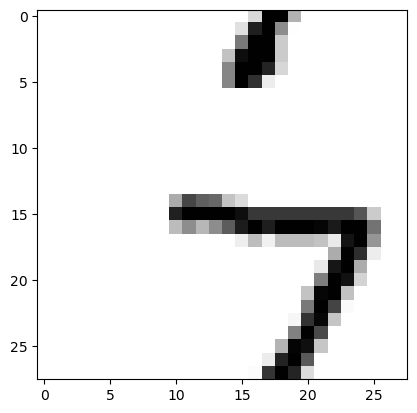

2 2


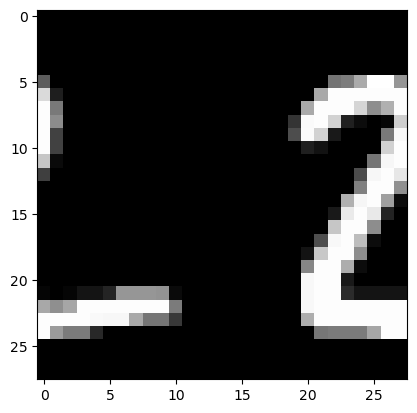

8 2


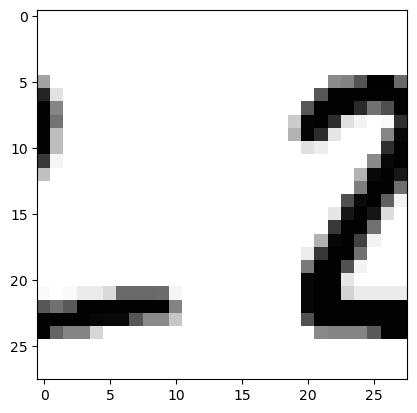

1 1


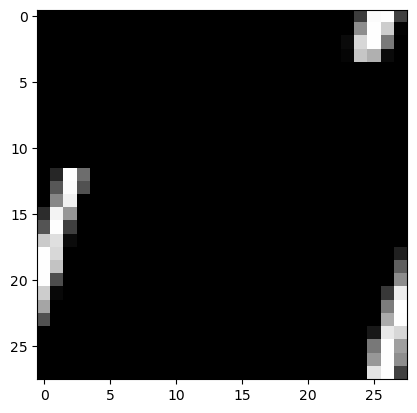

8 1


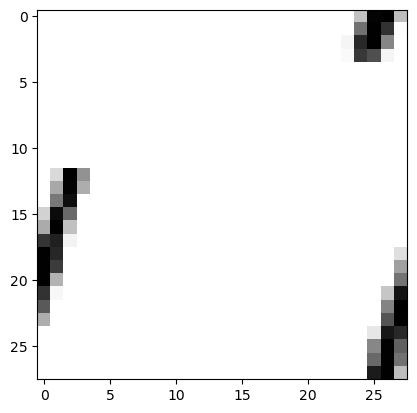

8 0


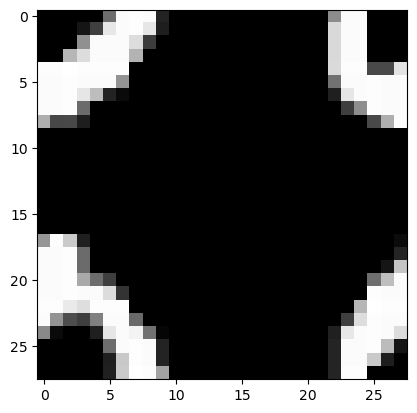

8 0


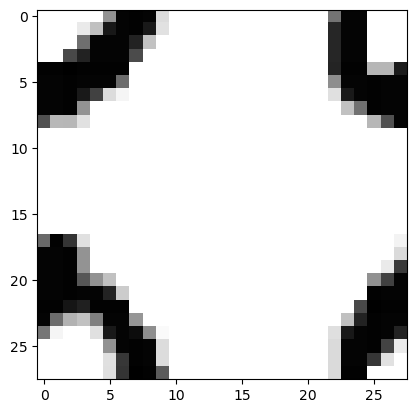

4 4


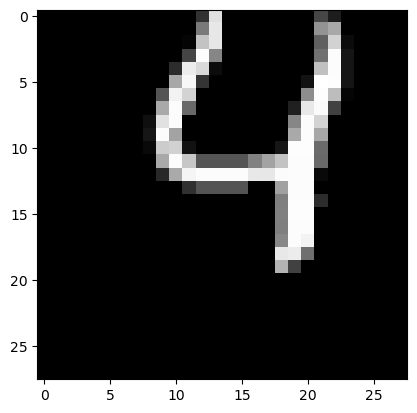

8 4


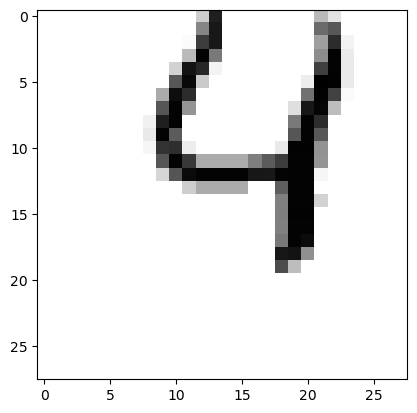

1 1


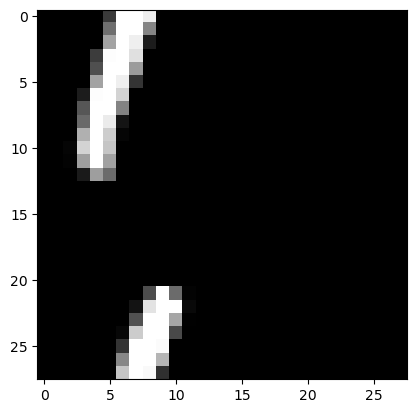

8 1


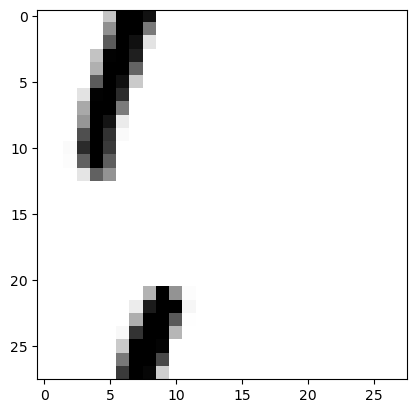

9 4


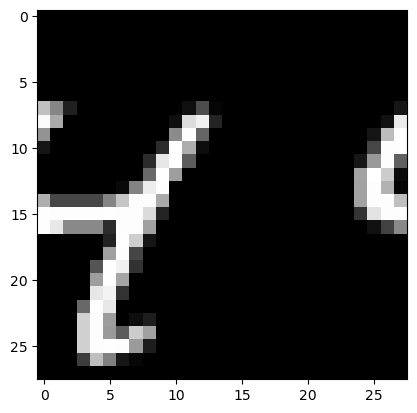

8 4


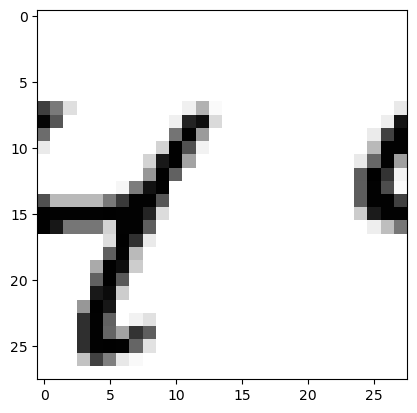

9 9


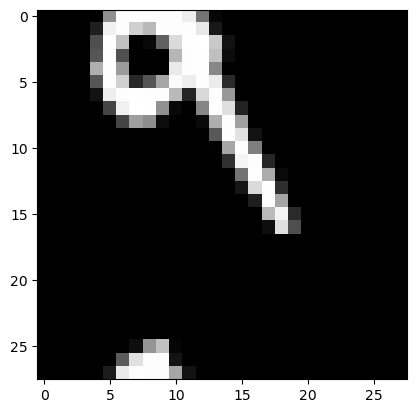

8 9


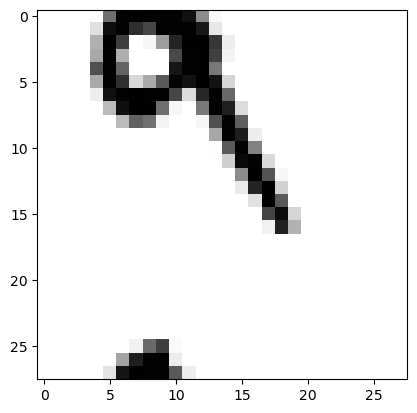

2 5


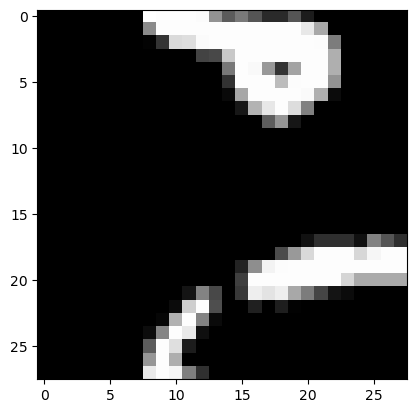

0 5


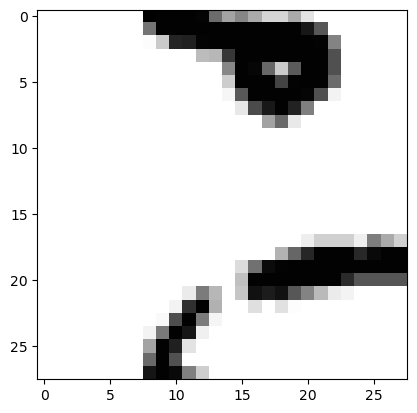

9 9


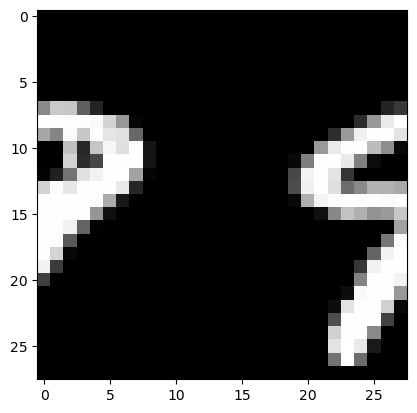

8 9


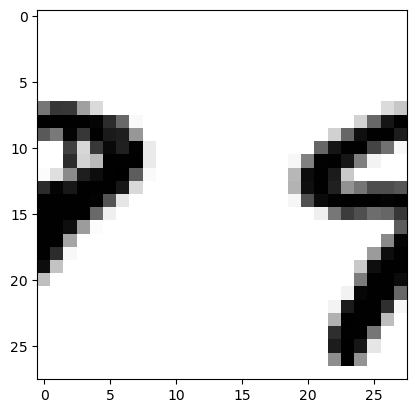

0 0


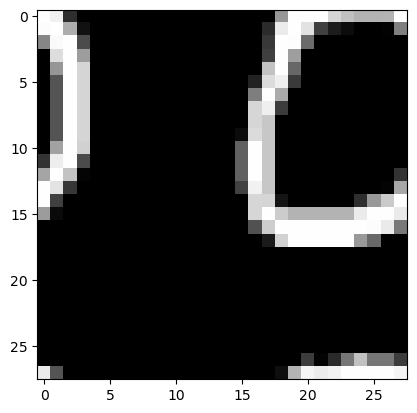

8 0


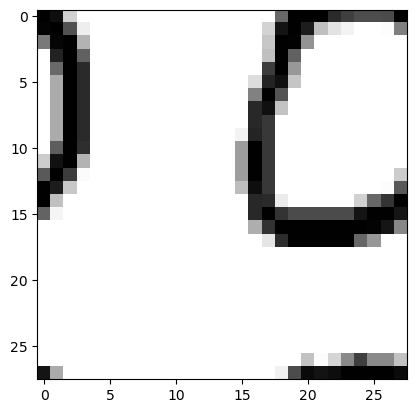

4 6


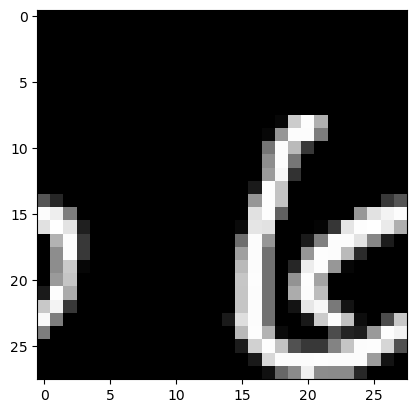

8 6


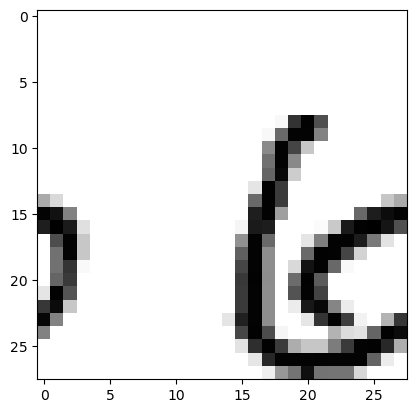

9 9


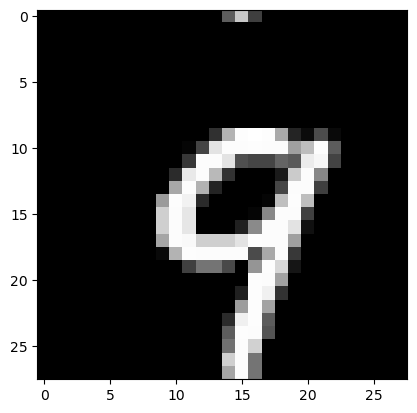

8 9


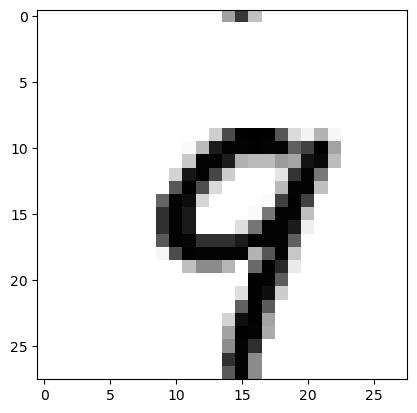

0 0


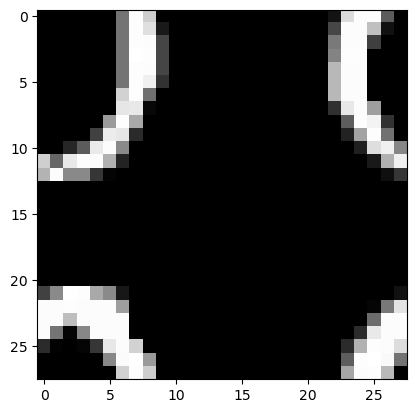

8 0


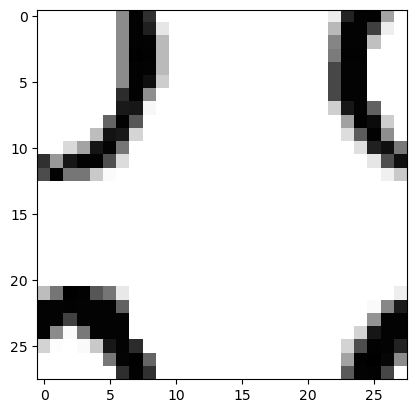

1 1


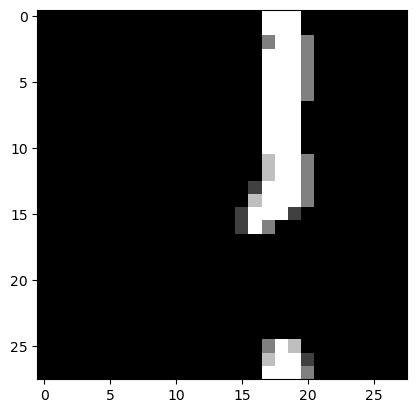

8 1


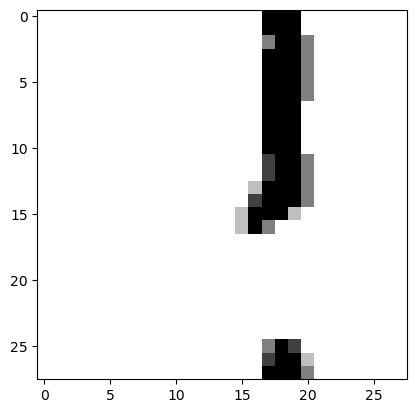

3 5


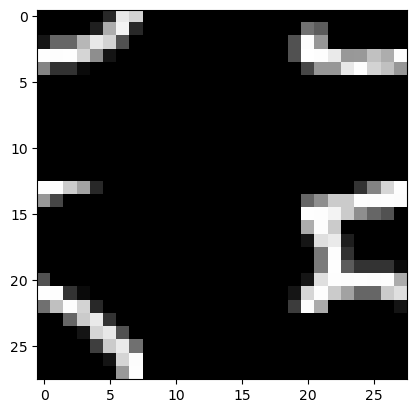

8 5


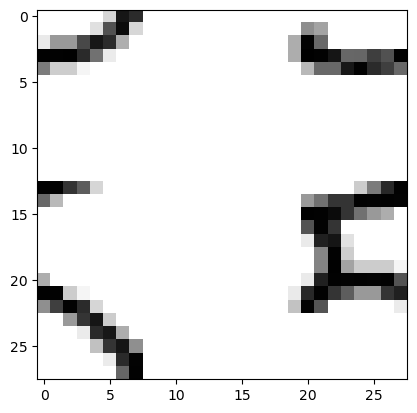

4 9


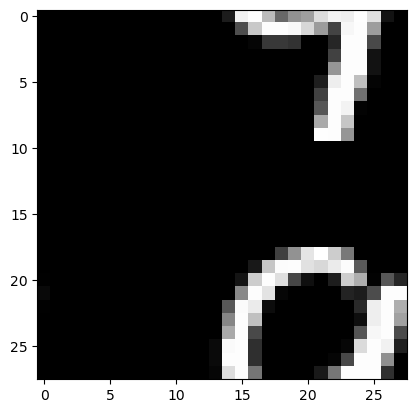

8 9


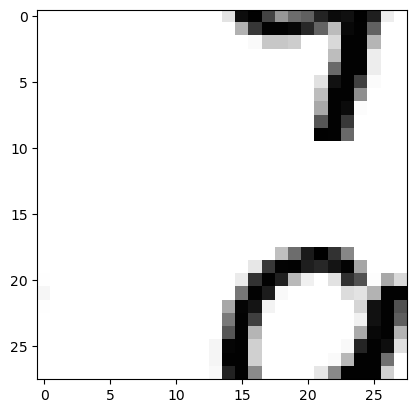

7 7


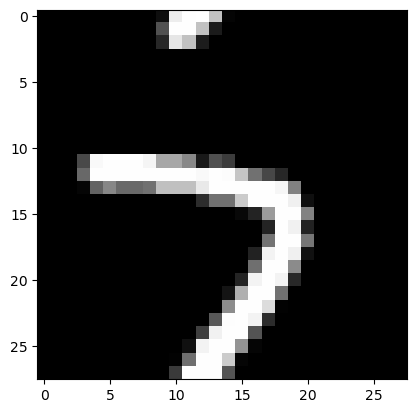

0 7


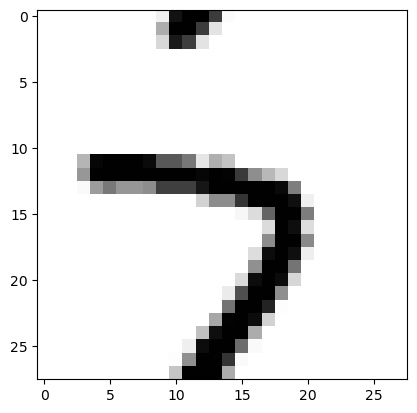

8 3


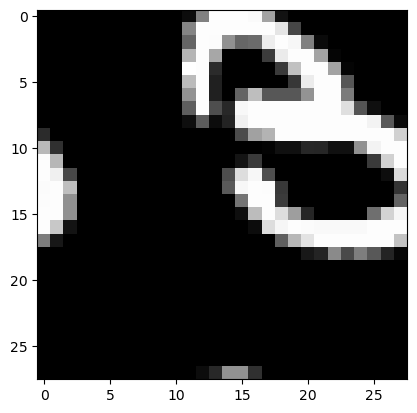

8 3


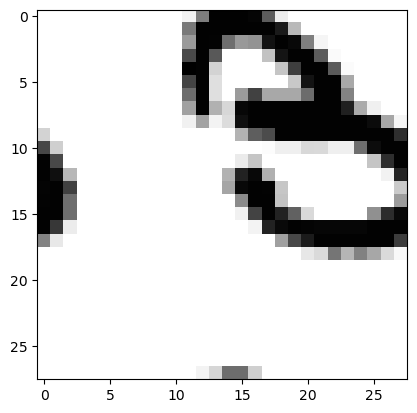

9 4


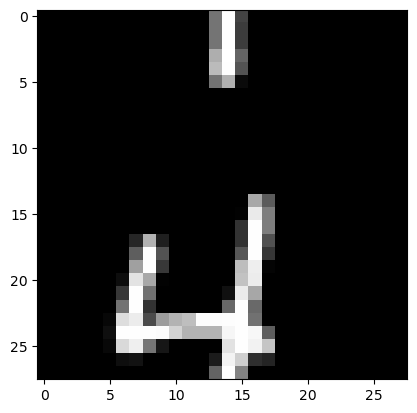

8 4


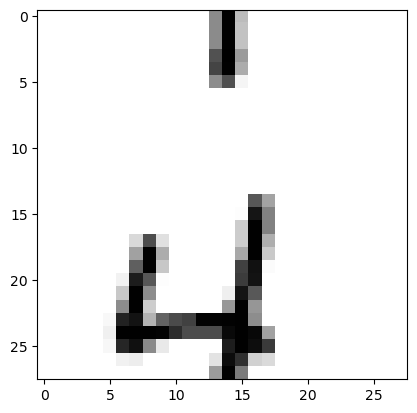

In [10]:
for i in range(20):
    print(clean_pred[i].item(), labels[i].item())
    plt.imshow(images[i][0], cmap='gray')
    plt.show()
    print(adv_pred[i].item(), labels[i].item())
    plt.imshow(advs[i][0], cmap='gray')
    plt.show()

In [11]:
for i in range(10):
    print(i,': ', len(adv_pred[adv_pred == i]))

0 :  2695
1 :  0
2 :  0
3 :  0
4 :  0
5 :  0
6 :  0
7 :  0
8 :  7305
9 :  0


In [12]:
n = [len(adv_pred[adv_pred == i]) for i in range(10)]

In [13]:
true_frac = [len(labels[labels == i])/total for i in range(10)]
clean_frac = [len(clean_pred[clean_pred == i])/total for i in range(10)]
frac = [len(adv_pred[adv_pred == i])/total for i in range(10)]

In [14]:
frac

[0.2695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7305, 0.0]

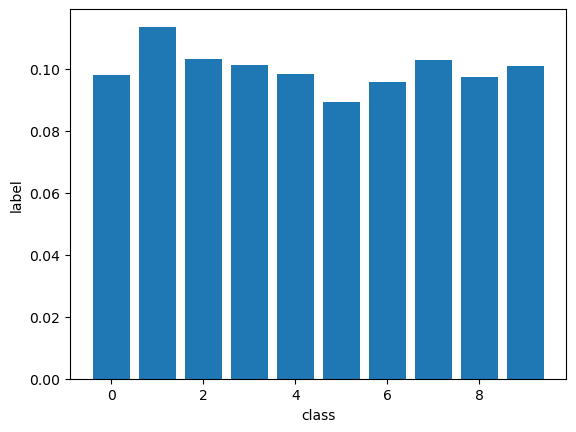

In [15]:
plt.bar(torch.arange(10), true_frac)
plt.xlabel('class')
plt.ylabel('label')
plt.show()

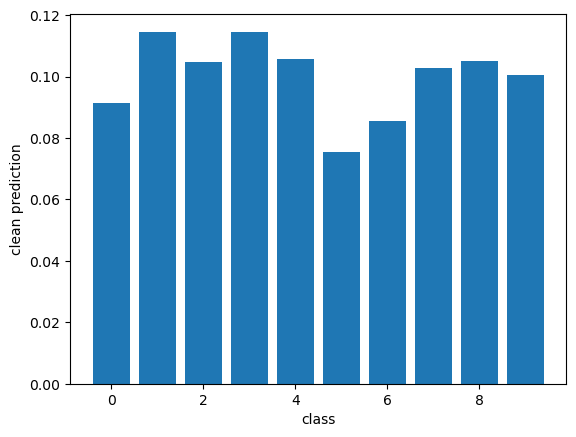

In [16]:
plt.bar(torch.arange(10), clean_frac)
plt.xlabel('class')
plt.ylabel('clean prediction')
plt.show()

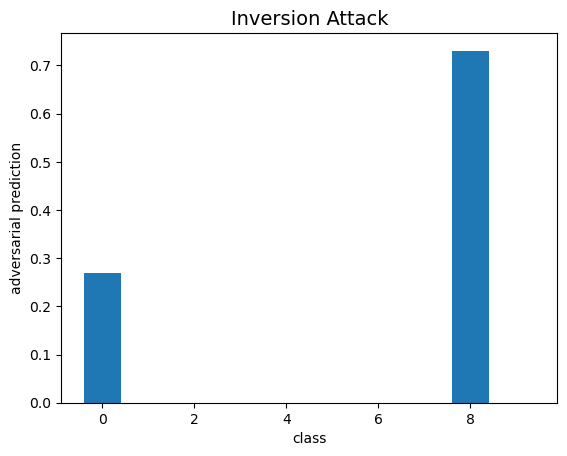

In [17]:
plt.title('Inversion Attack', fontsize=14)
plt.bar(torch.arange(10), frac)
plt.xlabel('class')
plt.ylabel('adversarial prediction')
plt.show()

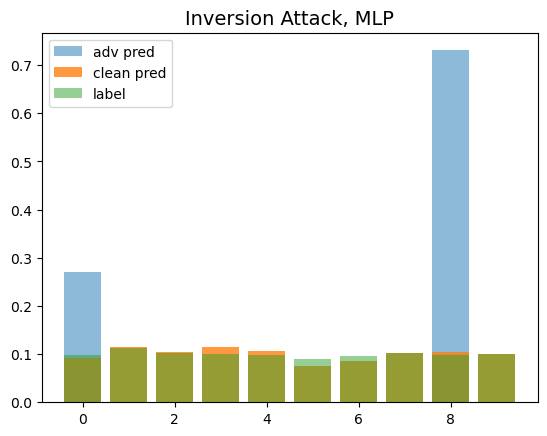

In [18]:
plt.title('Inversion Attack, MLP', fontsize=14)
plt.bar(torch.arange(10), frac, label='adv pred', alpha=0.5)
plt.bar(torch.arange(10), clean_frac, label='clean pred', alpha=0.8)
plt.bar(torch.arange(10), true_frac, label='label', alpha=0.5)

plt.legend()

plt.show()